In [1]:
import math
import numpy as np
from functools import reduce
from collections import defaultdict

_size_data = 0
_dim = 0

def generate_codebook(data, size_codebook, epsilon=0.00005):
    """
    This function will generate the codebook by given the data and the given size. Epsilon is the threshold taht used 
    during splitting and looping.
    """
    global _size_data, _dim

    _size_data = len(data)
    assert _size_data > 0

    _dim = len(data[0])
    assert _dim > 0

    codebook = []
    codebook_abs = [_size_data]
    codebook_rel = [1.0]

    # get the initial codevector by taking the average vector of whole input data
    c0 = avg_all_vectors(data, _dim, _size_data)
    codebook.append(c0)

    # initial average distortion
    avg_dist = initial_avg_distortion(c0, data)

    # splitting process until we have exactly same number of codevector with the size of codebook.
    while len(codebook) < size_codebook:
        codebook, codebook_abs, codebook_rel, avg_dist = split_codebook(data, codebook,
                                                                        epsilon, avg_dist)
    #return the result
    return codebook, codebook_abs, codebook_rel

def split_codebook(data, codebook, epsilon, initial_avg_dist):
    """
    Split into 2 codebook the get the best centroid as the new codevector.
    """

    # split into 2
    new_cv = []
    for c in codebook:
        # plus and minus epsilon for the new codebook
        c1 = new_codevector(c, epsilon)
        c2 = new_codevector(c, -epsilon)
        new_cv.extend((c1, c2))

    codebook = new_cv
    len_codebook = len(codebook)
    abs_weights = [0] * len_codebook
    rel_weights = [0.0] * len_codebook

    # Get the best centroid by taking average distortion as cost function. This problems mimic K-Means.
    avg_dist = 0
    err = epsilon + 1
    num_iter = 0
    while err > epsilon:
        # Get nearest codevector.
        closest_c_list = [None] * _size_data    # nearest codevector
        vecs_near_c = defaultdict(list)         # input data vector mapping
        vec_idxs_near_c = defaultdict(list)     # input data index mapping
        for i, vec in enumerate(data):  # for each input vector
            min_dist = None
            closest_c_index = None
            for i_c, c in enumerate(codebook):
                d = get_mse(vec, c)
                # Get the nearest ones.
                if min_dist is None or d < min_dist:
                    min_dist = d
                    closest_c_list[i] = c
                    closest_c_index = i_c
            vecs_near_c[closest_c_index].append(vec)
            vec_idxs_near_c[closest_c_index].append(i)

        # Update the codebook
        for i_c in range(len_codebook):
            vecs = vecs_near_c.get(i_c) or []
            num_vecs_near_c = len(vecs)
            if num_vecs_near_c > 0:
                # assign as new center
                new_c = avg_all_vectors(vecs, _dim)
                codebook[i_c] = new_c
                for i in vec_idxs_near_c[i_c]:
                    closest_c_list[i] = new_c

                # update the weights
                abs_weights[i_c] = num_vecs_near_c
                rel_weights[i_c] = num_vecs_near_c / _size_data

        # Recalculate average distortion
        prev_avg_dist = avg_dist if avg_dist > 0 else initial_avg_dist
        avg_dist = avg_codevector_dist(closest_c_list, data)

        # Recalculate the new error value
        err = (prev_avg_dist - avg_dist) / prev_avg_dist
        num_iter += 1

    return codebook, abs_weights, rel_weights, avg_dist

def avg_all_vectors(vecs, dim=None, size=None):
    """
    This function will get the average of whole data.
    """
    size = size or len(vecs)
    nvec = np.array(vecs)
    nvec = nvec / size
    navg = np.sum(nvec, axis=0)
    return navg.tolist()

def new_codevector(c, e):
    """
    This function will create a new codevector when we split into two.
    """
    nc = np.array(c)
    return (nc * (1.0 + e)).tolist()

def initial_avg_distortion(c0, data, size=None):
    """
    This function will calculate the average distortion of a vector to the input list of vectors.
    """
    size = size or _size_data
    nc = np.array(c0)
    nd = np.array(data)
    f = np.sum(((nc-nd)**2)/size)
    return f

def avg_codevector_dist(c_list, data, size=None):
    """
    This function will calculate the average distortion between list of vector and the input data.
    """
    size = size or _size_data
    nc = np.array(c_list)
    nd = np.array(data)
    f = np.sum(((nc-nd)**2)/size)
    return f

def get_mse(a, b):
    """
    This function will get the squared error, the mean will be calculate later.
    """
    na = np.array(a)
    nb = np.array(b)
    return np.sum((na-nb)**2)

In [12]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_training(img, block):
    """
    This function will generate the training codevector from the image via non-overlapped patch.
    """
    train_vec = []
    x = block[0]
    y = block[1]
    for i in range(0, img.shape[0], x):
        for j in range(0, img.shape[1], y):
            train_vec.append(img[i:i + x, j:j + y].reshape((x * y)))
    return (np.array(train_vec))

def generate_multi_training(path_list, block):
    """
    This function will generate the training codevector from the multi-image via non-overlapped patch.
    """
    img_list = []
    for path in path_list:
        img_list.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
    train_vec = []
    x = block[0]
    y = block[1]
    for img in img_list:
        for i in range(0, img.shape[0], x):
            for j in range(0, img.shape[1], y):
                train_vec.append(img[i:i + x, j:j + y].reshape((x * y)))
    return (np.array(train_vec))


def distance(a, b):
    """
    This function will calculate the distance (MSE) of two vectors.
    """
    return np.mean((np.subtract(a, b) ** 2))


def closest_match(src, cb):
    """
    This function will get the closest distance (nearest) of the compared vectors.
    """
    c = np.zeros((cb.shape[0],))
    for i in range(0, cb.shape[0]):
        c[i] = distance(src, cb[i])
    minimum = np.argmin(c, axis=0)
    return minimum


def encode_image(img, cb, block):
    """
    This function will encode (compress) the image by sending the image block, vectorize it then get the index of the 
    closest vector to form the compressed data.
    """
    x = block[0]
    y = block[1]
    compressed = np.zeros((img.shape[0] // y, img.shape[1] // x))
    ix = 0
    for i in range(0, img.shape[0], x):
        iy = 0
        for j in range(0, img.shape[1], y):
            src = img[i:i + x, j:j + y].reshape((x * y)).copy()
            k = closest_match(src, cb)
            compressed[ix, iy] = k
            iy += 1
        ix += 1
    return compressed


def decode_image(cb, compressed, block):
    """
    This function will decode the compressed data beck to the image by taking the index of the codebook then copy the associate vector to the image block.
    """
    x = block[0]
    y = block[1]
    original = np.zeros((compressed.shape[0] * y, compressed.shape[1] * x))
    ix = 0
    for i in range(0, compressed.shape[0]):
        iy = 0
        for j in range(0, compressed.shape[1]):
            original[ix:ix + x, iy:iy + y] = cb[int(compressed[i, j])].reshape(block)
            iy += y
        ix += x
    return original


def save_weight(filename, cb):
    """
    This function will save the absolute and relative weight as CSV file.
    """
    fd = open(filename, 'a')
    for i in range(0, cb.shape[0]):
        linecsv = str(cb[i]) + '\n'
        fd.write(linecsv)
    fd.close()


def save_codebook(filename, cb):
    """
    This function will save the codebook as CSV file.
    """
    fd = open(filename, 'a')
    for i in range(0, cb.shape[0]):
        linecsv = ''
        for j in range(0, cb.shape[1]):
            linecsv = linecsv + str(cb[i, j]) + ','
        linecsv = linecsv + '\n'
        fd.write(linecsv)
    fd.close()


def save_csv(root, csv, cb, cb_abs_w, cb_rel_w):
    """
    This function will save the codebook and weight as CSV file given the associate name.
    """
    numpy_cb = np.array(cb)
    numpy_abs_w = np.array(cb_abs_w)
    numpy_rel_w = np.array(cb_rel_w)
    save_codebook(root + 'CB_' + csv + '.csv', numpy_cb)
    save_weight(root + '3CB_abs_' + csv + '.csv', numpy_abs_w)
    save_weight(root + '3CB_rel_' + csv + '.csv', numpy_rel_w)


def sim_protocol(img, cb_size, epsilon, block, root, outpng):
    """
    This function needod for doing simulation for different scenario.
    """
    train_X = generate_training(img, block)
    cb, cb_abs_w, cb_rel_w = generate_codebook(train_X, cb_size, epsilon)
    cb_n = np.array(cb)
    cb_abs_w_n = np.array(cb_abs_w)
    cb_rel_w_n = np.array(cb_rel_w)
    result = encode_image(img, cb_n, block)
    final_result = decode_image(cb_n, result, block)
    fig = plt.gcf()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    plt.imshow(final_result, cmap='gray')
    cv2.imwrite(root + outpng + '.png', final_result)
    save_csv(root, outpng, cb_n, cb_abs_w_n, cb_rel_w_n)

def sim_multi_protocol(path_list, cb_size, epsilon, block, root, outpng):
    """
    This function needod for doing simulation for different scenario.
    """
    train_X = generate_multi_training(path_list, block)
    cb, cb_abs_w, cb_rel_w = generate_codebook(train_X, cb_size, epsilon)
    cb_n = np.array(cb)
    cb_abs_w_n = np.array(cb_abs_w)
    cb_rel_w_n = np.array(cb_rel_w)
    img = cv2.imread(path+'boat.png', cv2.IMREAD_GRAYSCALE) #Executing only for the boat image
    result = encode_image(img, cb_n, block)
    final_result = decode_image(cb_n, result, block)
    fig = plt.gcf()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    plt.imshow(final_result, cmap='gray')
    cv2.imwrite(root + outpng + '.png', final_result)   
    save_csv(root, outpng, cb_n, cb_abs_w_n, cb_rel_w_n)
    print('Weight Saved as: '+outpng)

def sim_testing_protocol(inpath_list, weight, block, outpng):
    """
    This function needod for doing simulation for different scenario.
    """
    fig, ax = plt.subplots(nrows=1, ncols=4)
    idx = 1
    for inpath in inpath_list:
        img = cv2.imread(inpath, cv2.IMREAD_GRAYSCALE)
        cb = pd.read_csv(weight, header=None).as_matrix().astype('int')
        cb = cb[:,0:cb.shape[1]-1]
        result = encode_image(img, cb, block)
        final_result = decode_image(cb, result, block)
        rem = inpath.replace('./images/', '')
        cv2.imwrite(outpng + rem.replace('.csv',''), final_result)
        psnr_value = psnr(img, final_result)
        ax = plt.subplot(1, 4, idx)
        ax.set_title('PSNR = {}'.format(psnr_value))
        ax.imshow(final_result, cmap='gray')
        idx+=1
    fig.set_figheight(6)
    fig.set_figwidth(24)
    plt.show()


def psnr(img1, img2):
    """
    This function will calculate the PSNR of two images.
    """
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


def measure_psnr(apath, bpath):
    """
    This function will doing PSNR comparison of two images.
    """
    img1 = cv2.imread(apath, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(bpath, cv2.IMREAD_GRAYSCALE)
    print('PSNR: {}'.format(psnr(img1, img2)))

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Original")
    ax1.imshow(img1, cmap='gray')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title("Result")
    ax2.imshow(img2, cmap='gray')

    fig.set_figheight(7)
    fig.set_figwidth(14)
    plt.show()

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
path = '/Users/talhaibnmahmud/Desktop/Theory Course/ECE 63400/Project2/sample_image/'
root = '/Users/talhaibnmahmud/Desktop/Theory Course/ECE 63400/Project2/'

CPU times: user 28.5 s, sys: 191 ms, total: 28.7 s
Wall time: 28.7 s


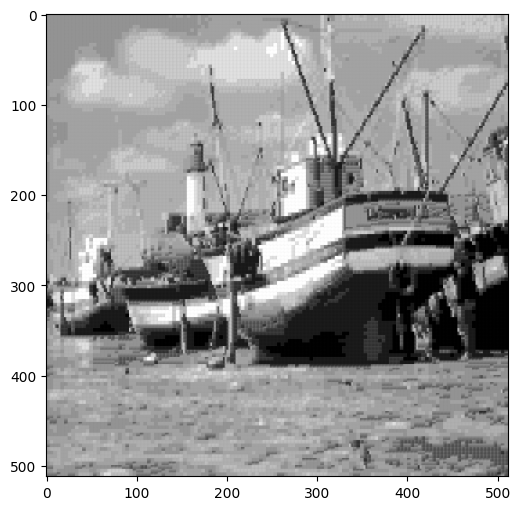

In [5]:
img = cv2.imread(path+'boat.png', cv2.IMREAD_GRAYSCALE)
%time sim_protocol(img, 16, 0.0005, (4,4), root, 'boat_16_0.0005')

CPU times: user 56 s, sys: 486 ms, total: 56.5 s
Wall time: 56.2 s


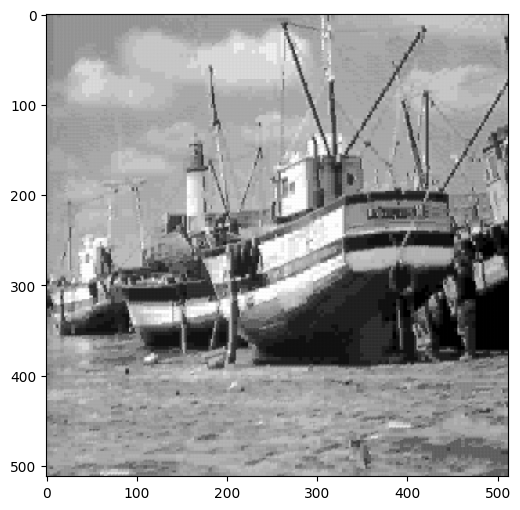

In [6]:
img = cv2.imread(path+'boat.png', cv2.IMREAD_GRAYSCALE)
%time sim_protocol(img, 32, 0.0005, (4,4), root, 'boat_32_0.0005')

CPU times: user 2min 9s, sys: 559 ms, total: 2min 10s
Wall time: 2min 9s


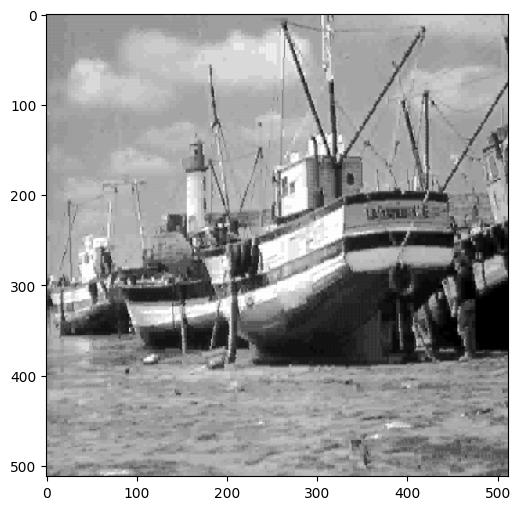

In [7]:
img = cv2.imread(path+'boat.png', cv2.IMREAD_GRAYSCALE)
%time sim_protocol(img, 64, 0.0005, (4,4), root, 'boat_64_0.0005')

Training with 10 images

Weight Saved as: airplane_boat_64_8_0.0005
CPU times: user 1min 17s, sys: 706 ms, total: 1min 18s
Wall time: 1min 18s


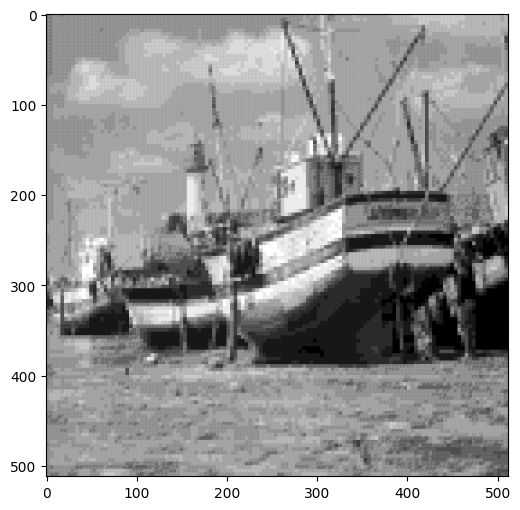

In [20]:
%time sim_multi_protocol([path+'airplane.png', path+'fruits.png', path+'girl.png', path+'goldhill.png', path+'boat.png'], 16, 0.0005, (4,4), root, 'airplane_boat_64_4_0.0005')